### 패키지 설치

**참고**
- transformers: 허깅페이스의 표준 트렌스포머 모델
- accelerate: 셀프 어텐선의 가속 모듈
- datasets==2.14.0: 사용할 데이터셋 로더의 버전 문제로 과거 버전 사용

In [5]:
!pip install transformers datasets==2.14.0 accelerate fsspec==2023.9.2

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.16
    Uninstalling multiprocess-0.70.16:
      Successfully uninstalled multiprocess-0.70.16
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import PatchTSTConfig, PatchTSTForPrediction
from datasets import load_dataset

### 사전학습된 모델 다운로드
- Hugging Face Hub에는 다양한 데이터셋으로 사전학습된 PatchTST 모델들이 공개되어 있습니다.
- 본 실습에서는 ETTh1 데이터셋으로 학습된 모델을 사용합니다.

### 사용할 모델:
- 모델 이름: ibm/patchtst-etth1-pretrain
- 학습 데이터: ETTh1 (Electricity Transformer Temperature - Hourly)
- 예측 대상: 전력 변압기의 온도 및 부하 데이터

In [2]:
# 사전학습된 모델 로드
model_name = "ibm/patchtst-etth1-forecasting"

model = PatchTSTForPrediction.from_pretrained(model_name)
print('✓ 모델 다운로드 및 로드 완료!')
print(f'모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}개')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✓ 모델 다운로드 및 로드 완료!
모델 파라미터 수: 614,496개


In [3]:
# 모델 설정 확인
config = model.config
print('=== 모델 설정 정보 ===')
print(f'입력 시퀀스 길이(context_length): {config.context_length}')
print(f'예측 길이(prediction_length): {config.prediction_length}')
print(f'패치 길이(patch_length): {config.patch_length}')
print(f'패치 간격(stride): {config.patch_stride}')
print(f'입력 채널 수(num_input_channels): {config.num_input_channels}')
print(f'히든 차원(d_model): {config.d_model}')
print(f'레이어 수(num_layers): {config.num_hidden_layers}')

=== 모델 설정 정보 ===
입력 시퀀스 길이(context_length): 512
예측 길이(prediction_length): 96
패치 길이(patch_length): 12
패치 간격(stride): 12
입력 채널 수(num_input_channels): 7
히든 차원(d_model): 128
레이어 수(num_layers): 3


### ETTh1 데이터셋 다운로드

In [4]:
# ETTh1 데이터셋 로드
dataset = load_dataset('ETDataset/ett', 'h1', multivariate=True)
print('✓ 데이터셋 다운로드 완료!')
print(f'Train 데이터: {len(dataset["train"])}개')
print(f'Test 데이터: {len(dataset["test"])}개')

✓ 데이터셋 다운로드 완료!
Train 데이터: 1개
Test 데이터: 240개


In [5]:
# 테스트 데이터에서 첫 번째 샘플 추출
test_sample = dataset['test'][0]

# 시계열 데이터 추출 (7개 채널)
ts_data = test_sample['target']
print(f'원본 시계열 길이: {len(ts_data[0])}')

# 모델 입력을 위한 데이터 준비
# context_length만큼의 과거 데이터 사용
context_length = config.context_length
prediction_length = config.prediction_length

원본 시계열 길이: 8664


### 시각화

데이터 형태: (7, 8664)


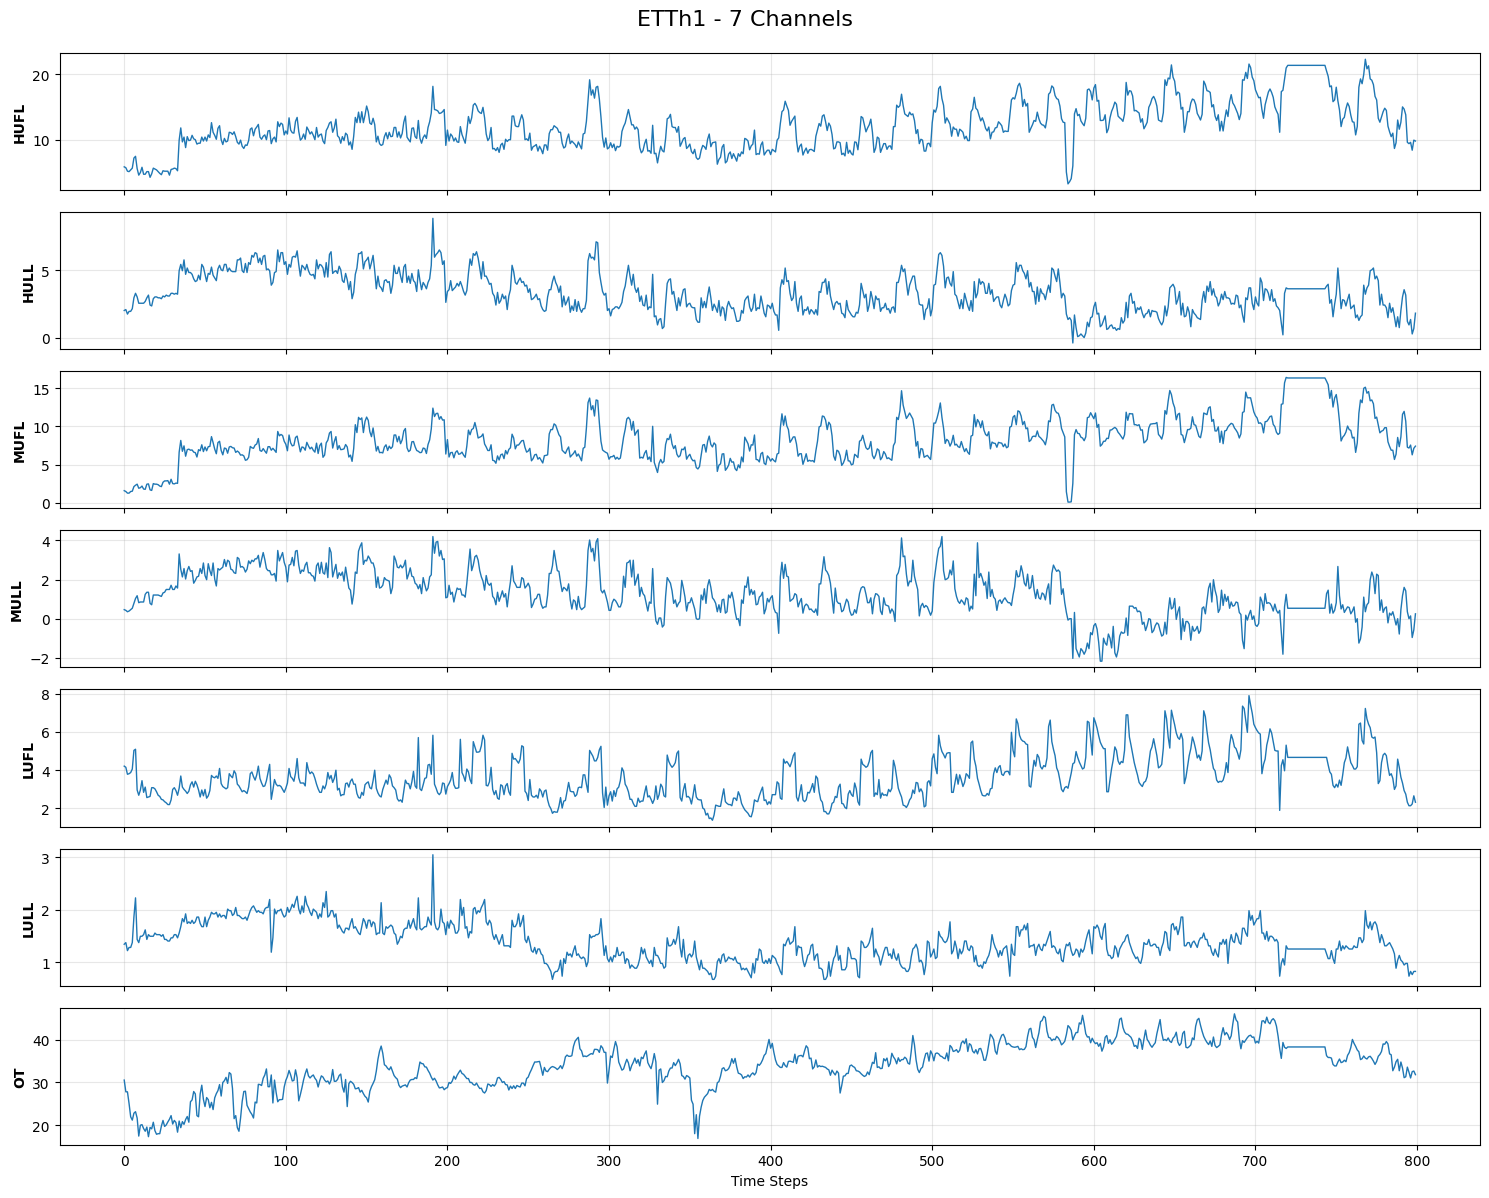

In [6]:
# 데이터 형태 확인 및 시각화
ts_array = np.array(ts_data)
print(f'데이터 형태: {ts_array.shape}')  # [채널 수, 시퀀스 길이]

# ETTh1 데이터셋의 7개 채널 이름
channel_names = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

# 7개 채널 시각화
fig, axes = plt.subplots(7, 1, figsize=(15, 12))
fig.suptitle('ETTh1 - 7 Channels', fontsize=16, y=0.995)

# 시각화할 데이터 포인트 수 (너무 많으면 일부만)
num_points = min(800, len(ts_array[0]))

for i in range(7):
    axes[i].plot(ts_array[i, :num_points], linewidth=1)
    axes[i].set_ylabel(channel_names[i], fontsize=10, fontweight='bold')
    axes[i].grid(True, alpha=0.3)

    # 마지막 subplot에만 x축 라벨 표시
    if i == 6:
        axes[i].set_xlabel('Time Steps', fontsize=10)
    else:
        axes[i].set_xticklabels([])

plt.tight_layout()
plt.show()


### 예측!

In [7]:
# 입력 데이터 준비 (선행하는 context_length 개 타임스텝)
# ts_data 형태: [7, total_timesteps]
past_values = np.array(ts_data)[:, -context_length-prediction_length:-prediction_length]  # [7, 512]
past_values = past_values.T  # [512, 7]로 전치
print(f'입력 데이터 형태: {past_values.shape}')

# 정답 데이터 준비 (입력 바로 다음의 prediction_length 개 타임스텝)
true_future = np.array(ts_data)[:, -prediction_length:]  # [7, prediction_length]
true_future = true_future.T  # [prediction_length, 7]로 전치
print(f'정답 데이터 형태: {true_future.shape}')

입력 데이터 형태: (512, 7)
정답 데이터 형태: (96, 7)


In [8]:
# 데이터 정규화 (각 채널별로 평균=0, 표준편차=1로 스케일링)
mean = past_values.mean(axis=0, keepdims=True)  # [1, 7]
std = past_values.std(axis=0, keepdims=True)    # [1, 7]
past_values_normalized = (past_values - mean) / (std + 1e-8)  # epsilon으로 0으로 나누기 방지
print(f'정규화 완료 - Mean: {mean.flatten()[:3]}, Std: {std.flatten()[:3]}')

정규화 완료 - Mean: [4.48841796 1.94733789 1.74584767], Std: [5.96380709 1.25656805 6.09296473]


In [9]:
# PyTorch 텐서로 변환
# 형태: [batch_size, sequence_length, num_channels]
past_values_tensor = torch.tensor(past_values_normalized).unsqueeze(0).float()  # [1, 512, 7]
print(f'입력 텐서 형태: {past_values_tensor.shape}')

print(f'  - batch_size: {past_values_tensor.shape[0]}')
print(f'  - sequence_length: {past_values_tensor.shape[1]}')
print(f'  - num_channels: {past_values_tensor.shape[2]}')

입력 텐서 형태: torch.Size([1, 512, 7])
  - batch_size: 1
  - sequence_length: 512
  - num_channels: 7


In [10]:
# 모델을 evaluation 모드로 설정
model.eval()

# 예측 수행
with torch.no_grad():  # 그래디언트 계산 비활성화 (예측만 수행)
  outputs = model(past_values=past_values_tensor)
  predictions = outputs.prediction_outputs

  print('✓ 예측 완료!')
  print(f'예측 결과 형태: {predictions.shape}')
  print(f'  - batch_size: {predictions.shape[0]}')
  print(f'  - prediction_length: {predictions.shape[1]}')
  print(f'  - num_channels: {predictions.shape[2]}')

✓ 예측 완료!
예측 결과 형태: torch.Size([1, 96, 7])
  - batch_size: 1
  - prediction_length: 96
  - num_channels: 7


In [11]:
# 예측값을 numpy 배열로 변환
predicted_values_normalized = predictions[0].cpu().numpy()

# 역정규화 (원래 스케일로 복원)
predicted_values = predicted_values_normalized * std + mean

# [prediction_length, num_channels]
print(f'변환된 예측값 형태: {predicted_values.shape}')
print(f'\n첫 5개 타임스텝의 예측값 (채널 0):')
print(predicted_values[:5, 0])

변환된 예측값 형태: (96, 7)

첫 5개 타임스텝의 예측값 (채널 0):
[ 9.68580092  9.76018279  9.93312315 10.71980981 10.55292631]


In [12]:
# 예측 성능 평가
mse = np.mean((predicted_values - true_future) ** 2)
mae = np.mean(np.abs(predicted_values - true_future))
rmse = np.sqrt(mse)

print(f'\n=== 예측 성능 ===')
print(f'MSE (Mean Squared Error): {mse:.4f}')
print(f'MAE (Mean Absolute Error): {mae:.4f}')
print(f'RMSE (Root Mean Squared Error): {rmse:.4f}')
print(f'\n첫 5개 타임스텝의 예측값 (채널 0):')
print(predicted_values[:5, 0])


=== 예측 성능 ===
MSE (Mean Squared Error): 4.6452
MAE (Mean Absolute Error): 1.3798
RMSE (Root Mean Squared Error): 2.1553

첫 5개 타임스텝의 예측값 (채널 0):
[ 9.68580092  9.76018279  9.93312315 10.71980981 10.55292631]


/tmp/ipython-input-670353851.py:31: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-670353851.py:31: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-670353851.py:31: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-670353851.py:31: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-670353851.py:31: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-670353851.py:31: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-670353851.py:31: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tm

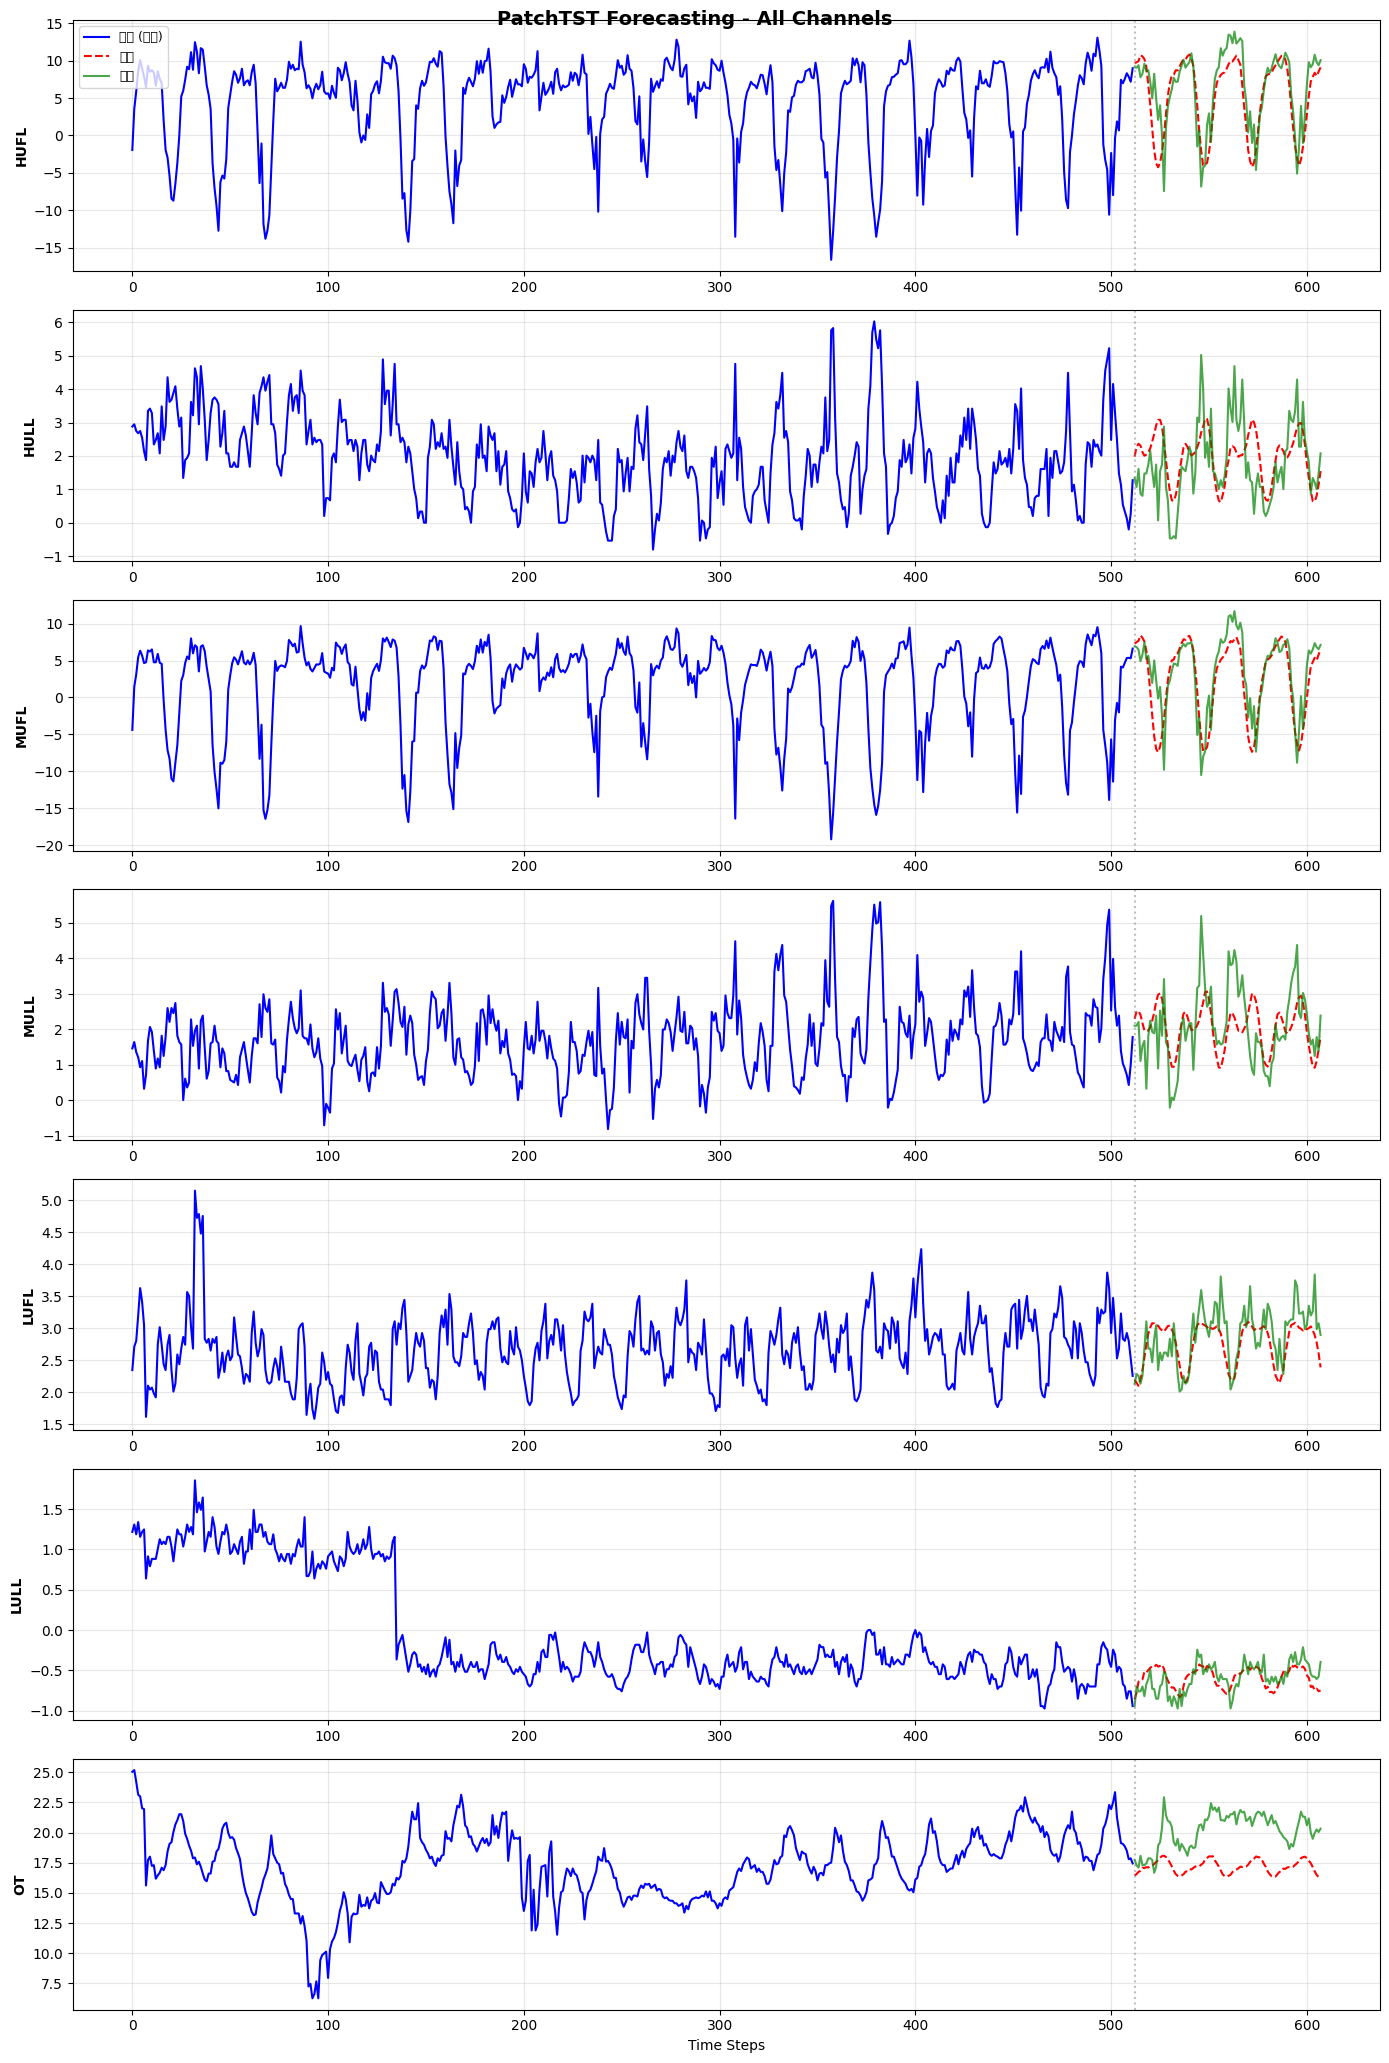

In [13]:
# 모든 채널에 대한 서브플롯 생성
num_channels = config.num_input_channels
fig, axes = plt.subplots(num_channels, 1, figsize=(14, 3*num_channels))

for i in range(num_channels):
    ax = axes[i] if num_channels > 1 else axes

    # 과거, 예측, 정답 데이터
    past = past_values[:, i]
    pred = predicted_values[:, i]
    true = true_future[:, i]

    # 플롯
    ax.plot(range(len(past)), past, color='blue', linewidth=1.5, label='과거 (입력)')

    pred_start = len(past)
    ax.plot(range(pred_start, pred_start + len(pred)), pred, color='red', linewidth=1.5, linestyle='--', label='예측')
    ax.plot(range(pred_start, pred_start + len(true)), true, color='green', linewidth=1.5, linestyle='-', alpha=0.7, label='정답')

    ax.axvline(x=len(past), color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
    ax.set_ylabel(f'{channel_names[i]}', fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)

    if i == 0:
        ax.legend(fontsize=9, loc='upper left')

    if i == num_channels - 1:
        ax.set_xlabel('Time Steps', fontsize=10)

plt.suptitle('PatchTST Forecasting - All Channels', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()